In [1]:
import sqlite3
import random
from string import punctuation

import pandas as pd
import numpy as np
from pandas.core.series import Series
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
offers_connection = sqlite3.connect('../../datasets/offers_dataset.db')
offers_frame = pd.read_sql_query('''SELECT * FROM offers''', offers_connection)
offers_connection.close()

with sqlite3.connect('../../datasets/skills_dataset.db') as skills_connection:
    skills_frame = pd.read_sql_query('SELECT * FROM skills', skills_connection)
    skills_frame.set_index('ID', inplace=True)

In [3]:
offers_frame.dropna(subset='Name',inplace=True)
offers_frame.drop_duplicates(inplace=True)
offers_frame

,Name,Description,Location
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata"
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia"
...,...,...,...
294,Machine Learning / Java Developer,Descripción¡En Qindel Group estamos creciendo!...,"A Coruña, A Coruña provincia"
295,Investigador predoctoral en Machine Learning,Función: - Entrenamiento de modelos de Deep Le...,"Madrid, Madrid provincia"
296,"Manager, Machine Learning Engineering",Affirm is reinventing credit to make it more h...,"Barcelona, Barcelona provincia"
297,Machine Learning Ops/Engineer,Attendance to the office in a hybrid work mode...,"28033 Madrid, Madrid provincia"


In [4]:
def remove_symbols(description: str, remove_map: dict) -> str:
    """
    """
    for old, new in remove_map.items():
        description = description.replace(old, new)
    return description.lower()


def extract_symbols(description: str, available_symbols: list) -> set:
    s = set()
    prev = ''
    for word in description.split():
        if word in available_symbols:
            s.add(word)
        elif f'{prev} {word}' in available_symbols:
            s.add(f'{prev} {word}')  
        prev = word
    return s 

def translate_skills(skills: set, toId = False) -> set:
    if toId:
        return skill_to_id(skills)
    else:
        return id_to_skill(skills)

def id_to_skill(skills: set[int]) -> set[str]:
    out = set()
    for skill in skills:
        out.add(skills_frame.loc[skill, 'SKILL'])
    
    return out

def skill_to_id(skills: set[str]) -> set[int]:
    out = set()
    for skill in skills:
        out.add(
            list(
                skills_frame.loc[
                    skills_frame['SKILL'].apply(lambda val: val.lower()) == skill.lower()
                ].index
            )[0]
        )
    
    return out

In [5]:
# Get Skill list
skills_list = [skill.lower() for skill in skills_frame['SKILL'].tolist()]

# Symbols to remove
punct = [p for p in punctuation]
punct.remove('+')
punct.remove('#')
# punct.remove('.')

removal = {p: ' ' for p in punct}
removal['\n'] = ''
removal['/'] = ' '
removal['('] = ' '
removal[')'] = ' '
removal[','] = ' '
removal['>'] = ' '
removal['.'] = ' .'

In [6]:
required_skills = [] 

# Extract skills from descriptions and add new column
for i, offer_description in enumerate(offers_frame.loc[:, 'Description']):
    desc = remove_symbols(offer_description, removal)
    offer_skills = extract_symbols(desc, skills_list)
    required_skills.append(translate_skills(offer_skills, toId=True))  
    #required_skills.append(offer_skills)
offers_frame.insert(len(offers_frame.columns), "RequiredSkills", required_skills)

# Remove offers with no required skills
offers_frame['RequiredSkills'] = offers_frame['RequiredSkills'].apply(lambda x: np.NaN if not x else x)
offers_frame.dropna(subset='RequiredSkills', inplace=True)
offers_frame.reset_index(drop=True, inplace=True)
offers_frame

,Name,Description,Location,RequiredSkills
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{2, 6, 7, 8, 9}"
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{0, 3, 6, 44, 26}"
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{8, 9, 2}"
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{0, 1, 99, 3, 6, 7, 104, 55, 57, 26}"
...,...,...,...,...
237,Machine Learning / Java Developer,Descripción¡En Qindel Group estamos creciendo!...,"A Coruña, A Coruña provincia","{2, 3, 6, 31}"
238,Investigador predoctoral en Machine Learning,Función: - Entrenamiento de modelos de Deep Le...,"Madrid, Madrid provincia",{2}
239,"Manager, Machine Learning Engineering",Affirm is reinventing credit to make it more h...,"Barcelona, Barcelona provincia","{2, 59, 58, 3}"
240,Machine Learning Ops/Engineer,Attendance to the office in a hybrid work mode...,"28033 Madrid, Madrid provincia","{32, 2, 67, 89, 30, 31}"


### Jaccard Distance

In [7]:
def _jaccard(s1: set, s2: set):
    return 1 - (len(s1.intersection(s2)) / len(s1.union(s2)))

def jaccard(row1: Series, row2: Series, col_name: str):
    if row1.keys().values is not row2.keys().values:
        raise ValueError(f'Rows have different columns: {row1.keys()} vs {row2.keys()}')   
    if col_name not in row1.keys() or col_name not in row2.keys():
        raise ValueError(f'Invalid Column Name {col_name}')  
    return _jaccard(row1[col_name], row2[col_name])

In [8]:
# Examples
r1 = offers_frame.loc[8, :]
r2 = offers_frame.loc[37, :]
r3 = offers_frame.loc[random.randint(0, len(offers_frame))]
r4 = offers_frame.loc[random.randint(0, len(offers_frame))]

print(f'Distance between {r1["Name"]} and {r1["Name"]}: {jaccard(r1, r1, "RequiredSkills"):.2f}\n {r1["RequiredSkills"]} and {r1["RequiredSkills"]}')
print(f'Distance between {r1["Name"]} and {r2["Name"]}: {jaccard(r1, r2, "RequiredSkills"):.2f}\n {r1["RequiredSkills"]} and {r2["RequiredSkills"]}')
print(f'Distance between {r3["Name"]} and {r4["Name"]}: {jaccard(r3, r4, "RequiredSkills"):.2f}\n {r3["RequiredSkills"]} and {r4["RequiredSkills"]}')

Distance between Frontend and Frontend: 0.00
 {0, 1, 99} and {0, 1, 99}
Distance between Frontend and Software Developer Degree Apprenticeship (Nottingham): 1.00
 {0, 1, 99} and {6, 7, 9, 57, 30}
Distance between Frontend Developer (React) Freelance and JAVA DEVELOPER (FULL REMOTE): 1.00
 {0, 1, 99, 73, 41, 18} and {26, 3, 61, 6}


## Distance Matrix

In [9]:
def get_distance_matrix(frame: pd.DataFrame, col_name: str):
    distances = []
    for i, row1 in frame.iterrows():
        distances.append([])
        for j, row2 in frame.iterrows():
            if i != j:
                distances[-1].append(_jaccard(row1[col_name], row2[col_name]))
            else:
                distances[-1].append(0)#np.inf) 
    return pd.DataFrame(distances, index=frame.index, columns=frame.index)

distance_matrix = get_distance_matrix(offers_frame, 'RequiredSkills')

In [10]:
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.0,0.000000,0.888889,0.400000,0.846154,0.833333,0.600000,1.000000,1.000000,0.833333,...,0.900000,0.833333,0.714286,0.833333,0.818182,0.714286,0.800000,0.875000,0.900000,0.833333
2,1.0,0.888889,0.000000,1.000000,0.636364,0.833333,0.833333,1.000000,0.857143,0.833333,...,0.900000,0.833333,0.714286,0.833333,0.916667,0.714286,1.000000,0.875000,1.000000,1.000000
3,1.0,0.400000,1.000000,0.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,...,0.875000,0.750000,0.833333,0.750000,0.900000,0.833333,0.666667,0.833333,0.875000,0.750000
4,1.0,0.846154,0.636364,1.000000,0.000000,0.800000,0.909091,1.000000,0.700000,0.909091,...,0.933333,0.909091,0.833333,0.909091,0.941176,0.833333,1.000000,0.923077,1.000000,0.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,1.0,0.714286,0.714286,0.833333,0.833333,0.800000,0.500000,1.000000,1.000000,0.800000,...,0.750000,0.500000,0.000000,0.500000,0.666667,0.000000,0.750000,0.666667,0.750000,0.800000
238,1.0,0.800000,1.000000,0.666667,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,...,0.833333,0.500000,0.750000,0.500000,0.875000,0.750000,0.000000,0.750000,0.833333,0.500000
239,1.0,0.875000,0.875000,0.833333,0.923077,1.000000,0.800000,1.000000,1.000000,1.000000,...,0.333333,0.500000,0.666667,0.500000,0.909091,0.666667,0.750000,0.000000,0.888889,0.800000
240,1.0,0.900000,1.000000,0.875000,1.000000,1.000000,0.857143,1.000000,1.000000,1.000000,...,0.909091,0.857143,0.750000,0.857143,0.600000,0.750000,0.833333,0.888889,0.000000,0.857143


In [11]:
def similar_offers(offer_id: int, threshold: float = 0.6) -> list:
    """
    get similar offers based only on distance matrix
    """
    similar = []
    for item_id, distance in distance_matrix.iloc[offer_id].sort_values()[offer_id:].items():
        if distance > threshold:
            break
        similar.append(offers_frame.iloc[item_id])
    return similar

### Clustering based recommendation

**Silhouette Score**

Per valutare il clustering effettuato useremo il Silhouette Score invece dell'Elbow Point dato che è che il punto di gomito è meno efficace, di solito, con dati complessi, inoltre il Silhouette Score fornisce più dettagli riguardo alle relazioni, in particolare alla separazione, tra cluster.

Per interpretare i risultati del Silhouette Score è importante notare che i valori, che variano da -1 a +1 hanno i seguenti significati:
-  1: Gli Item sono assegnati a un cluster specifico e i cluster sono facilmente distinguibili.
-  0: I cluster si sovrappongono.
- -1: Gli Item vengono assegnati a cluster errati.

L'algoritmo di clustering proposto è il KMeans, questo perchè assumiamo che nuove Offerte aggiunte nel corso del ciclo di vita del prodotto finale possano appartenere a cluster già esistenti, in quanto le tipologie di figure professionali richieste nel settore dell'informatica variano raramente, possono però variare le competenze richieste in un certo settore specifico, è importante quindi la capacità dell'algoritmo di aggiornarsi.
Per scegliere il valore di *k* abbiamo deciso di provare a calcolare il punteggio di Silhouette per diversi valori di *k* e scegliere quello con il risultato migliore.

In [12]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean


def item_cluster_distance(frame: pd.DataFrame, item: Series, target: int, 
                          group_label: str = 'Group', 
                          distance_label: str = 'RequiredSkills'):
    """
    Computes distance between an item in a cluster X and the other items in a cluster Y.
    Used also when X and Y are the same clusters.
    """
    group = frame[frame[group_label] == target]
    den = len(list(group.index))
    distance = 0
    
    for it in group.iterrows():
        if not it[1].equals(item):
            distance += jaccard(item, it[1], distance_label)
    
    return distance/den

def find_nearest_cluster(centroids, target_label: int):
    nearest = None
    target_centroid = centroids.iloc[target_label]
    min_dist = float('inf')
    
    for label, vector in centroids[centroids.index != target_label].iterrows():
        dist = euclidean(target_centroid, vector)
        if dist < min_dist:
            min_dist = dist
            nearest = label
    
    return nearest


def kmeans_silhouette(frame: pd.DataFrame,
               clustering: KMeans,
               group_label: str = 'Group',
               distance_label: str = 'RequiredSkills'):
    
    silhouette_scores = []
    for target_cluster in list(np.unique(frame[group_label])): 
        nearest_cluster = find_nearest_cluster(
            pd.DataFrame(clustering.cluster_centers_),
            target_cluster
        )
        for _, item in frame.iterrows():
            a = item_cluster_distance(frame, item, target_cluster, group_label, distance_label)
            b = item_cluster_distance(frame, item, nearest_cluster, group_label, distance_label)
            silhouette_score = (b - a) / max(a, b)
            silhouette_scores.append(silhouette_score)
    
    return np.mean(silhouette_scores)

In [13]:
# --- See how many clusters perform the best
max_value = -2
best_value = 0
for k in range(2, 8):
    tmp_kmeans = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=42)
    labels = tmp_kmeans.fit_predict(distance_matrix)
    offers_frame['Group'] = labels
    
    value = kmeans_silhouette(offers_frame, tmp_kmeans)
    print(f'Value for {k}: {value:.3f}')
    if value > max_value:
        max_value = value
        best_value = k

C:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  Fi

Value for 2: 0.000
Value for 3: 0.020
Value for 4: 0.018
Value for 5: 0.020
Value for 6: 0.027
Value for 7: 0.021


In [46]:
# --- best
# k-means++ is best for high-dimensional data
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=5, random_state=42)
labels = kmeans.fit_predict(distance_matrix)
offers_frame['Group'] = labels

**Visualizzazione dei Cluster**

Visualizzare i risultati è importante per poter trarre delle conclusioni sulla qualità del clustering, la natura dei dati che bisogna visualizzare è però multidimensionale, questo può rendere arduo effettuare un plot; analizzando il problema possiamo dire che il nostro obbiettivo è *poter associare delle coordinate (x, y) a ogni Offerta nel dataset*, in particolare sfruttando la matrice delle distanze.
Per fare ciò useremo la riduzione delle dimensionalità tramite **Principal Component Analysis**. 

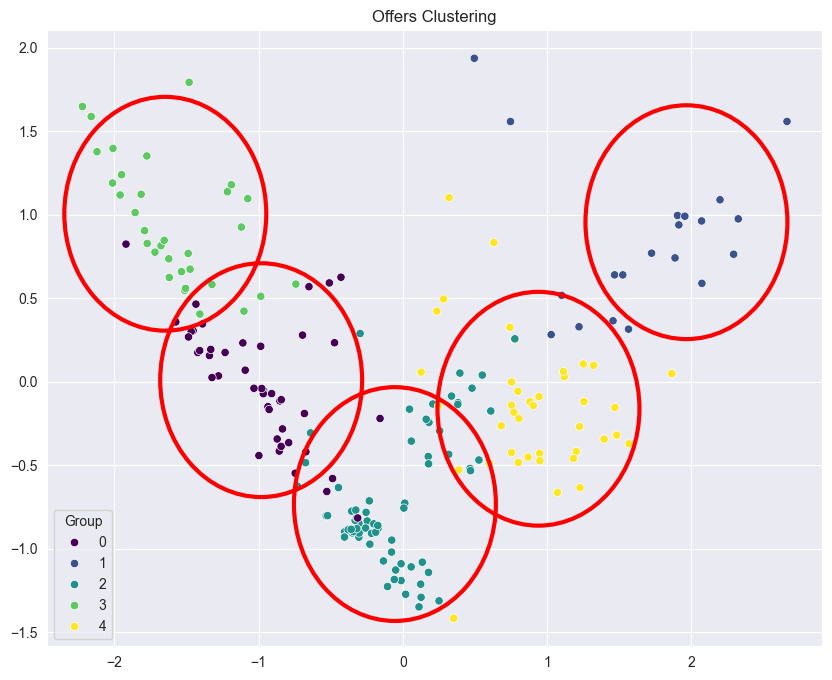

In [47]:
from sklearn.decomposition import PCA
from matplotlib.patches import Circle


pca = PCA(2)
group_labels = offers_frame['Group']
reduced_data = pca.fit_transform(distance_matrix)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=group_labels, palette='viridis')
plt.title('Offers Clustering')

groups = group_labels.unique()
for group in groups:
    group_data = reduced_data[labels == group]
    mean_x = group_data[:, 0].mean()
    mean_y = group_data[:, 1].mean()
    circle = Circle((mean_x, mean_y), 0.7, fill=False, linewidth=3, edgecolor='red')
    plt.gca().add_artist(circle)

plt.show()

Dopo aver analizzato lo scatterplot si è concluso che 6 cluster non erano buoni, in quanto due erano *"accavallati"*, quindi nonostante il punteggio di Silhouette fosse più alto si è optato per un **k = 5**, ottenendo così risultati migliori. 
***Nota**: abbiamo usato dei cerchi per evidenziare i gruppi, ma non sono rappresentativi della forma dei cluster, inoltre hanno una dimensione scelta in modo casuale*

In [50]:
offers_frame[offers_frame['Group'] == 1]

,Name,Description,Location,RequiredSkills,Group
20,Sviluppatore software,Cosa stiamo cercando \n Stiamo selezionando u...,37138 Verona,"{0, 2, 10, 3}",1
55,Electrochemical Modelling - Energy Storage Int...,Job Title:Electrochemical Modelling - Energy S...,Cambridge,{2},1
59,Macro Research Analyst and Associate Internshi...,Summer Internship Programme Overview \n Get ...,London E14,{2},1
99,Data Analyst,Tutti iniziano a lavorare e anche tu vorresti ...,"Roma, Lazio","{2, 3}",1
103,Gridspertise - Data and Intelligence Lead,General InformationCountryItalyState/RegionLom...,"Milano, Lombardia","{2, 18, 3}",1
104,DATA SCIENTIST,Per strutturata software house specializzata n...,"Conegliano, Veneto",{2},1
105,Simulation Machine Learning Analyst,Posting Date: 22 Jan 2024City: RomaLocation: R...,"Roma, Lazio","{43, 2, 3}",1
106,Business Intelligence & Data Modeling Analyst,"Risorse SpA, per importante realtà consulenzia...",27058 Voghera,"{2, 3}",1
113,Backend Engineer,What you'll be doing:- Collaborate with Produc...,London EC2A,{2},1
124,Data Scientist,Location: Remote (EU only)ProfileExperienced d...,None,"{2, 3}",1


**Esempi**

In [24]:
def _similar_offers_with_cluster(offer_id: int) -> list:
    target_group = offers_frame.loc[offer_id, 'Group']
    return list(
        offers_frame[
            offers_frame['Group'] == target_group
        ].index
    )

def similar_offers_with_cluster(offer_id: int) -> list:
    return [offers_frame.iloc[oid] for oid in _similar_offers_with_cluster(offer_id)]
offers_frame

,Name,Description,Location,RequiredSkills,Group
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}",5
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{2, 6, 7, 8, 9}",3
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{0, 3, 6, 44, 26}",0
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{8, 9, 2}",3
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{0, 1, 99, 3, 6, 7, 104, 55, 57, 26}",4
...,...,...,...,...,...
237,Machine Learning / Java Developer,Descripción¡En Qindel Group estamos creciendo!...,"A Coruña, A Coruña provincia","{2, 3, 6, 31}",2
238,Investigador predoctoral en Machine Learning,Función: - Entrenamiento de modelos de Deep Le...,"Madrid, Madrid provincia",{2},2
239,"Manager, Machine Learning Engineering",Affirm is reinventing credit to make it more h...,"Barcelona, Barcelona provincia","{2, 59, 58, 3}",2
240,Machine Learning Ops/Engineer,Attendance to the office in a hybrid work mode...,"28033 Madrid, Madrid provincia","{32, 2, 67, 89, 30, 31}",3


In [26]:
# Frontend: {css, javascript, html}
print(f'Offers Similar to {offers_frame.iloc[8]["Name"]}:\n')
for i, o in enumerate(similar_offers_with_cluster(8)):
    print(f'{i}> {o["Name"]} : {id_to_skill(o["RequiredSkills"])}')

Offers Similar to Frontend:

0> Senior Software Developer : {'C#', 'Linux', 'Oracle', 'SQL', 'HTML', 'Java', 'CSS', '.NET', 'JavaScript', 'AngularJS'}
1> Frontend : {'JavaScript', 'HTML', 'CSS'}
2> JUNIOR DEVELOPER : {'C#', 'SQL', 'HTML', 'CSS', '.NET', 'JavaScript', 'jQuery'}
3> L4 Software Developer Apprentice : {'Go', 'HTML', 'PHP', 'Git', 'C', 'CSS', 'JavaScript'}
4> Frontend Software Developer : {'React', 'Bash', 'HTML', 'Angular', 'CSS', 'JavaScript'}
5> Graduate Software Engineer (London) : {'AWS', 'HTML', 'Azure', 'Java', 'C', 'CSS', 'JavaScript'}
6> Software Developer : {'C#', 'SQL', 'HTML', 'CSS', '.NET', 'JavaScript', 'TypeScript'}
7> Web Development Manager : {'JavaScript', 'HTML', 'CSS', 'PHP'}
8> Freelance Web & UX Developer : {'JavaScript', 'HTML', 'CSS', 'PHP'}
9> Junior Web Developer : {'JavaScript', 'HTML', 'CSS'}
10> Web Developer Apprentice : {'JavaScript', 'C', 'HTML', 'CSS'}
11> Sviluppatore Web : {'MySQL', 'HTML', 'CSS', 'PHP'}
12> Sviluppatore Web - Middle/Senio

In [28]:
# Machine Learning Ops/Engineer
print(f'Offers Similar to {offers_frame.iloc[240]["Name"]}:\n')
for i, o in enumerate(similar_offers_with_cluster(240)):
    print(f'{i}> {o["Name"]} : {id_to_skill(o["RequiredSkills"])}')

Offers Similar to Machine Learning Ops/Engineer:

0> Junior Software Developer : {'C#', 'Python', 'Java', 'C', 'C++'}
1> Software Developer : {'C++', 'Python', 'C'}
2> IBP Junior Algorithms Software Development : {'Python', 'Java'}
3> Sviluppatore Java Junior : {'Java'}
4> Manufacturing Software Engineer / Relocation USA : {'C#', 'Python', 'SQL', 'Java', 'MySQL', 'C++'}
5> Software Developer - FULL REMOTE : {'C#', 'AWS', 'Python', 'Java', 'Azure'}
6> Software Engineer : {'C++', 'C', 'Java'}
7> Campus - Graduate Programme - Technology Graduate Software Engineer - 2024 (UK) : {'Express', 'Python', 'Kotlin', 'Go', 'Java', 'CSS', 'Spring'}
8> Software Developer Degree Apprenticeship (Nottingham) : {'C#', 'AWS', 'Java', '.NET', 'C'}
9> Software Engineering Lead : {'Java'}
10> System Software Engineer, Summer Intern - 2024 Start (Fixed-Term Contract) : {'Python', 'Linux', 'Rust', 'Java', 'C', 'C++'}
11> Cyber Security Analyst - Undergraduate : {'Python', 'C', 'Java'}
12> Energy Harvesting In

In [30]:
# Machine Learning / Java Developer
print(f'Offers Similar to {offers_frame.iloc[237]["Name"]}:\n')
for i, o in enumerate(similar_offers_with_cluster(237)):
    print(f'{i}> {o["Name"]} : {id_to_skill(o["RequiredSkills"])}')

Offers Similar to Machine Learning / Java Developer:

0> Sviluppatore software : {'JavaScript', 'Python', 'SQL', 'PHP'}
1> Electrochemical Modelling - Energy Storage Internship – Starting Summer 2024 (12 months) : {'Python'}
2> Macro Research Analyst and Associate Internship 2024 London : {'Python'}
3> Data Analyst : {'Python', 'SQL'}
4> Gridspertise - Data and Intelligence Lead : {'PostgreSQL', 'Python', 'SQL'}
5> DATA SCIENTIST : {'Python'}
6> Simulation Machine Learning Analyst : {'Express', 'Python', 'SQL'}
7> Business Intelligence & Data Modeling Analyst : {'Python', 'SQL'}
8> Backend Engineer : {'Python'}
9> Data Scientist : {'Python', 'SQL'}
10> DATA SCIENTIST | MACHINE LEARNING | BIG DATA : {'MongoDB', 'Python', 'SQL', 'Azure'}
11> EU Institutions: AI Machine Learning Data Scientist : {'MongoDB', 'Python', 'SQL', 'Swift'}
12> Cybersecurity Analyst : {'Python', 'Bash'}
13> Martech Analyst : {'JavaScript', 'Python', 'SQL', 'HTML'}
14> DEVOPS ENGINEER | INFRASTRUCTURE DEVOPS | FUL